# Iterative phase estimation

In this lab we will look at how to perform Quantum Phase estimation with minimum number of auxillary qubits and still retrieve the whole phase.

__Disclaimer__ : Recall from Lab 1 that we saw how to create and run jupyter (.ipynb) notebooks using IBM Quantum Lab. For this assignment, please continue using the same to avoid any installation issues.

Fill in your details in the below cell. \
Your Name :  Soham Chatterjee \
ID : BMC202175 

Rename your notebook with your ID as a suffix and submit in the moodle page.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()
import math
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister

# Iterative phase estimation

The quantum phase estimation (QPE) algorithm is one of the most important and famous quantum algorithms. It is a key subroutine of Shor's factoring algorithm, as well as algorithms for quantum simulation. The textbook version of the algorithm uses a number of auxiliary qubits which scales with the desired precision, leading to circuits that are challenging to execute on today's noisy devices with limited qubit number and connectivity.

Iterative phase estimation (IPE) is a variant of QPE which requires only one auxiliary qubit. In IPE, the auxiliary qubit is repeatedly measured, with the measurement results used to guide future quantum operations.

## Introduction

Like usual phase estimation algorithm, IPE is designed to solve the following problem:

**Problem statement:** Given a unitary matrix $U$ and an eigenstate $|\Psi\rangle$ of $U$ with an unknown eigenvalue $e^{i 2\pi \varphi}$, estimate the value of $\varphi$.

Let's first assume for simplicity that $\varphi$ can have an exact binary expansion, that is, it can be written as
$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$
where we are using "decimal" point notation in base 2.
Unlike the usual phase estimation algorithm where we would need $m$ auxillary qubits, IPE requires only single auxiliary qubit, lets call this qubit, $q$ for notational convenience.

Suppose that we initialize $q$ in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$. What happens if we apply the *controlled*-$U^{2^t}$ gate, with $q$ being the control, given that the target is an eigenstate of $U$ ?

Let $|\Psi \rangle$ be the eigenstate of $U$ with eigenvalue $e^{i 2\pi \varphi}$, we have
$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{\text{controlled-}U^{2^t}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$
The qubits on the eigenstate remains unchanged, while a phase of $e^{i 2 \pi 2^{t} \varphi}$ has been "kicked back" (similar to phase kickback in the Grover's algorithm) into the state of the auxiliary qubit $q$.

Let's look at what happens for different values of $t$
- for $t=0$, the phase would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$
- for $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$
- for $t=2$, the phase would be $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$
- for $t=m-1$, the phase would be $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$.

In the last case where $t = m - 1$, the phase is $e^{i 2 \pi 0.\varphi_m}$, which is equal to $1$ if $\varphi_m = 0$ and $-1$ if $\varphi_m = 1$.
In the first case, the auxiliary qubit $q$ would be in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, and in the second case it would be
in the state $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$. 

Therefore, measuring the qubit in the Pauli $X$ basis would distinguish these cases with a 100\% success rate.
This is done by performing a Hadamard gate on the qubit before measuring it. 

In the first case we would measure 0 and in the second case we would measure 1; in other words, the measured bit would be equal to $\varphi_m$.

### The algorithm

1. Initialize the circuit with the eigenstate $|\Psi\rangle$.
2. Initialize the auxillary qubit in state $|+\rangle$.
3. Perform a *controlled*-$U^{2^{m-1}}$ operation, and measuring $q$ in the Pauli $X$ basis. This gives us the value of the least significant bit $\varphi_{m}$.
4. Reset the auxillary qubit using reset gate available in qiskit.
5. For the next step apply a *controlled*-$U^{2^{m-2}}$ operation. The relative phase in $q$ after these operations is now $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. \
To extract the phase bit $\varphi_{m-1}$, first perform a phase correction by rotating around the $Z$-axis by an angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. Perform a measurement on $q$ in the Pauli $X$ basis to obtain the phase bit $\varphi_{m-1}$. \
This is where the main advantage lies, rotating the auxillary qubit at step $k$ based on the known information till step $k-1$.

6. Repeat the same procedure for $m$ steps to retrieve the entire phase $\varphi_1,\varphi_2,...,\varphi_m$

For cases like step 5 in the IPE algorithm, we need the power to apply quantum gates conditioned on the output measured onto classical registers. This ability is r3eferred to as [dynamic circuits](https://research.ibm.com/blog/quantum-dynamic-circuits) by IBM. 

Below is an example of how to perform these operations in qiskit where we reset a qubit by measuring. If the measured value is 0, do nothing ; if the measured value is 1 apply a NOT (X) gate.

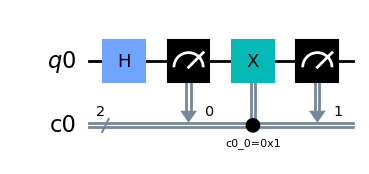

In [2]:
# An example of how to apply a quantum gate controlled on classical output
qreg = QuantumRegister(1)
creg = ClassicalRegister(2)
reset_circ = QuantumCircuit(qreg,creg)
reset_circ.h(0)
reset_circ.measure(qreg[0],creg[0])
reset_circ.x(0).c_if(creg[0],1) # the c_if operation checks if the value of creg[0] is 1. If yes, then applies x gate on the qubit 0
reset_circ.measure(qreg[0],creg[1])
reset_circ.draw()

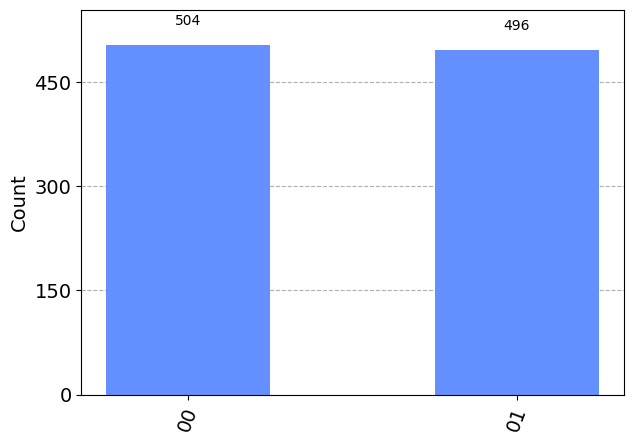

In [3]:
# Running the above circuit should give me 0 always in the first bit (creg[1]) irrespective of what the input qubit is.
# Feel free to initialize the qubit to any arbitrary state and check.
sim = AerSimulator()
job = sim.run(reset_circ, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## Implementation

In this lab, we will perform IPE on the single-qubit $S$-gate. The $S$ gate is given by the matrix

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

We will use the eigenstate $|\Psi\rangle = |1\rangle$, which has eigenvalue $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. So we have $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$. Since $\varphi$ can be represented exactly with 2 bits (i.e., $m=2$), our quantum circuit implementation will use a classical register with two bits to store the result.

The controlled-$S$ gate can be implemented using the controlled phase gate, available in Qiskit as `CPhaseGate`, which can also be applied by calling the `cp` method of a `QuantumCircuit`. The controlled phase gate is parameterized by an angle $\theta$ and has the matrix
$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


### Step 1

The first step of the algorithm is to measure the least significant bit $\varphi_2$. Measure this onto the first bit of the classical register, cr[0]

In [ ]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np

# For convenience, the corresponding number of registers in the circuit are given below.

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')
qc = QuantumCircuit(qr, cr)

# Fill your code below to find the least significant bit of the phase of S gate.
qc.h(0)
qc.x(1) # Initialize the qubit with |1>
# Applied C(S^{2-1}) where m=2 since we are estimating till 2nd  bit
qc.cp(theta = (2**(2-1))*math.pi/2, control_qubit=[0],  target_qubit=[1]) 
qc.h(0)
qc.measure(0,0)

qc.draw("mpl")

### Step 2

In the second step (also final step for our case), we extract the next bit $\varphi_1$. This involves the following steps.

1. Reset and re-initialize the auxiliary qubit to $|+\rangle$.
2. Apply the controlled unitary gate.
3. Apply a phase correction based on the measured value of $\varphi_2$. \
    If $\varphi_2=cr[0]=1$ apply a phase rotation of $-\pi/2$ to the auxillary qubit $q$; else do nothing.
4. Measure the auxiliary qubit in the $X$ basis onto the other classical bit, cr[1]. (i.e., apply Hadamard and then measure)

In [ ]:
# Fill your code below for the step 2
qc.reset(0)
qc.h(0) # Auxiliary qubit reset and reinitialized to |1>
qc.cp(theta = (2**(2-2))*math.pi/2, control_qubit=[0],  target_qubit=[1]) 
# If the 2nd bit is 1 then apply the phase corresction by -2pi/4 = -pi/2
qc.p(theta = -2*math.pi/(2**2), qubit = [0]).c_if(0,1)
qc.h(0)
qc.measure(0,1)
qc.draw("mpl")

## Run on simulator

Now that we have the complete circuit, let's first run it on a local simulator.

__Note__ : If you are using any custom gates make sure to transpile the circuit and then run

In [ ]:
sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

If your circuit is correct, you should have gotten the bitstring `01` with 100% probability. This value corresponds to the phase written in binary as $\varphi = 0.01 = 1/4$. Indeed, this is the correct phase! 

The approach can be generalized to any phase $\varphi$, keeping the number of auxillary qubits is always fixed to be 1.

## Question 3

Extend the iterative phase estimation approach we have seen above to find phase of the following unitary

$$ U =
\begin{pmatrix}
1 & 0\\
0 & e^{3\pi i/ 4}
\end{pmatrix}$$

Note that the phase $\varphi = 3\pi/8 = 0.011$ (in binary), so in total you need to perform 3 steps iteratively to find all the bits of $\varphi$.  

In [ ]:
# Your code for creating the circuit goes here
qr = QuantumRegister(2,'q')
cr = ClassicalRegister(3,'c')
qc = QuantumCircuit(qr, cr)
#####################
###### Step 1 #######
#####################
qc.h(0)
qc.x(1) # Initialize the qubit with |1>
# Applied C(S^{2-1}) where m=2 since we are estimating till 2nd  bit
qc.cp(theta = (2**(3-1))*3*math.pi/4, control_qubit=[0],  target_qubit=[1]) 
qc.h(0)
qc.measure(0,0)
#####################
###### Step 2 #######
#####################
qc.reset(0)
qc.h(0) # Auxiliary qubit reset and reinitialized to |1>
qc.cp(theta = (2**(3-2))*3*math.pi/4, control_qubit=[0],  target_qubit=[1]) 
# If the 2nd bit is 1 then apply the phase corresction by -2pi/8 = -pi/4
qc.p(theta = -2*math.pi/(2**2), qubit = [0]).c_if(0,1)
qc.h(0)
qc.measure(0,1)
#####################
###### Step 3 #######
#####################
qc.reset(0)
qc.h(0) # Auxiliary qubit reset and reinitialized to |1>
qc.cp(theta = (2**(3-3))*3*math.pi/4, control_qubit=[0],  target_qubit=[1])
# If the 3rd bit is 1 then apply the phase corresction by -2pi/8 = -pi/4
qc.p(theta = -2*math.pi/(2**3), qubit = [0]).c_if(0,1)
# If the 2nd bit is 1 then apply the phase corresction by -2pi/4 = -pi/2
qc.p(theta = -2*math.pi/(2**2), qubit = [0]).c_if(1,1)
qc.h(0)
qc.measure(0,2)
qc.reset(0)
qc.draw('mpl')

In [ ]:
# Run on a simulator and plot counts
sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

__Credits__ : A similar question was solved in Qiskit Spring Challenge 2023